In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vision Warehouse Product Search
<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/vijaykyr/genai-demos/blob/main/vision_warehouse/Vision_Warehouse_Product_Search.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
</table>

# Overview

[Vision Warehouse](https://cloud.google.com/vision-ai/docs/warehouse-overview) enables developers to integrate storage and AI-based search of unstructured media content into existing tools and applications.

In this notebook we will demonstrated the use of Vision Warehouse to store product catalog data and then conduct AI powered multimodal search on the catalog including:

- Downloading Product Catalog Dataset
- Creating Vision Warehouse Corpus
- Defining Schema
- Importing Assets
- Generating Embeddings
- Creating and Deploying Index
- Text-to-Image Search
- Image-to-Image Search

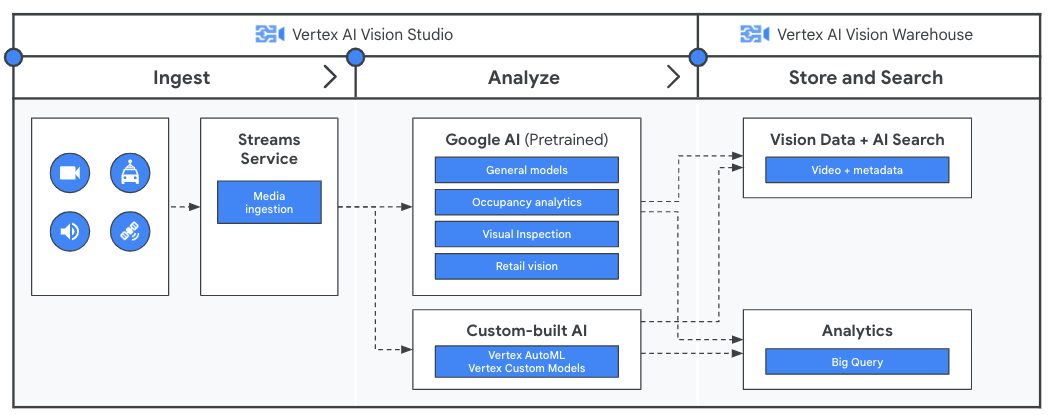

# Setup

## Install Dependencies (If Needed)

The list `packages` contains tuples of package import names and install names. If the import name is not found then the install name is used to install quitely for the current user.

In [2]:
!gsutil cp gs://visionai-artifacts/visionai-0.0.6-py3-none-any.whl .

Copying gs://visionai-artifacts/visionai-0.0.6-py3-none-any.whl...
/ [1 files][377.8 KiB/377.8 KiB]                                                
Operation completed over 1 objects/377.8 KiB.                                    


In [3]:
# tuples of (import name, install name)
packages = [
    ('visionai','visionai-0.0.6-py3-none-any.whl'), # Vision Warehouse Client
    ('opendatasets','opendatasets'), # Helper for Kaggle Datasets
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

installing package visionai-0.0.6-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.4/454.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 25.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.
installing package opendatasets


## Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [4]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Authenticate

If you are using Colab, you will need to authenticate yourself to GCP. The next cell will check if you are currently using Colab, and will start the authentication process.

In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

# If using local jupyter instance, uncomment and run:
# !gcloud auth login

## Config

Update the below variables to specify the GCP project ID and GCS storage location you want to use

In [2]:
GCP_PROJECT_ID = "YOUR_PROJECT_ID"  # @param {type:"string"}
GCS_IMAGE_BUCKET = 'flipkart_1000' # @param {type:"string"}
GCS_IMAGE_FOLDER = 'flipkart_images' # @param {type:"string"}

#Do NOT modify below
REGION = "us-central1" # only region currently supported
PROJECT_NUMBER_STR = !gcloud projects describe $GCP_PROJECT_ID --format="value(projectNumber)"
PROJECT_NUMBER = int(PROJECT_NUMBER_STR[0])

## Import Libraries

In [3]:
import math
import time

import ipywidgets
import requests
from IPython.display import display
from ipywidgets import GridspecLayout
from visionai.python.gapic.visionai import visionai_v1
from visionai.python.net import channel

#Instantiate Vision Wareshouse Client
warehouse_endpoint = channel.get_warehouse_service_endpoint(channel.Environment['PROD'])
warehouse_client = visionai_v1.WarehouseClient(
    client_options={"api_endpoint": warehouse_endpoint}
)

# Dataset

For this demonstration we will use the [Kaggle Flipkart Product Catalog Dataset](https://www.kaggle.com/datasets/PromptCloudHQ/flipkart-products)

This is a pre-crawled dataset of 20K products that was created by extracting data from [Flipkart.com](https://www.flipkart.com/), a leading Indian eCommerce store.

## Download

Since this data is hosted on Kaggle you will need a Kaggle account to download it. The next cell will prompt you for your credentials. If you don't have a Kaggle account you can [create one](https://www.kaggle.com/account/login?phase=startRegisterTab&returnUrl=%2F) for free and then return to the notebook.

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/PromptCloudHQ/flipkart-products/download")

## Sample

For our purposes we'll take the first 1000 products and a subset of fields.

In [8]:
import pandas as pd
full_df = pd.read_csv('flipkart-products/flipkart_com-ecommerce_sample.csv')
full_df.dropna(inplace=True) # Drop rows with missing values
df = full_df[['uniq_id','product_name','image','description','retail_price']][:1000]
df

,uniq_id,product_name,image,description,retail_price
0,c2d766ca982eca8304150849735ffef9,Alisha Solid Women's Cycling Shorts,"[""http://img5a.flixcart.com/image/short/u/4/a/...",Key Features of Alisha Solid Women's Cycling S...,999.0
1,7f7036a6d550aaa89d34c77bd39a5e48,FabHomeDecor Fabric Double Sofa Bed,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...,32157.0
2,f449ec65dcbc041b6ae5e6a32717d01b,AW Bellies,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",Key Features of AW Bellies Sandals Wedges Heel...,999.0
3,0973b37acd0c664e3de26e97e5571454,Alisha Solid Women's Cycling Shorts,"[""http://img5a.flixcart.com/image/short/6/2/h/...",Key Features of Alisha Solid Women's Cycling S...,699.0
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,Sicons All Purpose Arnica Dog Shampoo,"[""http://img5a.flixcart.com/image/pet-shampoo/...",Specifications of Sicons All Purpose Arnica Do...,220.0
...,...,...,...,...,...
1614,cd3b9feb267ae454462f5fe00cce61e5,Blissdrizzle Crystal Bracelet,"[""http://img6a.flixcart.com/image/bangle-brace...",Blissdrizzle Crystal Bracelet - Buy Blissdrizz...,399.0
1616,1cf93e056f8d60de1564bc13ab6986a3,SR Crafts Showpiece - 15.24 cm,"[""http://img6a.flixcart.com/image/showpiece-fi...","SR Crafts Showpiece - 15.24 cm (Polyresin, M...",1850.0
1617,db35f0fa09496d5320dffbdcd2b504f4,Voylla Alloy Jewel Set,"[""http://img5a.flixcart.com/image/jewellery-se...",Voylla Alloy Jewel Set - Buy Voylla Alloy Jewe...,1129.0
1618,9f6f759f02fb9d5436f8ca5fb3bc3108,Transcend MP 870 8 GB MP4 Player,"[""http://img6a.flixcart.com/image/audioplayer/...",Buy Transcend MP 870 8 GB MP4 Player only for ...,4225.0


## Download Images and Upload to GCS

Vision Warehouse requires that images be stored in GCS. First lets define some utility functions

In [26]:
# Define some util functions
from google.cloud import storage
from google.cloud.storage import Bucket

def create_gcs_bucket(bucket_name: str):
  storage_client = storage.Client(GCP_PROJECT_ID)
  try:
    storage_client.get_bucket(GCS_IMAGE_BUCKET)
    print("Bucket already exists")
  except:
    print("Bucket does not exist")
    bucket = storage_client.create_bucket(GCS_IMAGE_BUCKET)
    print(f"Bucket {bucket.name} created.")

def extract_url(image_list: str) -> str:
  for char in ['[', ']', '"']:
    image_list = image_list.replace(char, '')
  return image_list.split(',')[0]

def upload_product_images(df):
  df['gcs_uri'] = ''
  num_rows = len(df)
  for i, (id, image_list) in enumerate(zip(df['uniq_id'], df['image'])):
    image_url = extract_url(image_list)
    image_file_name = f'{id}.jpg'
    destination_blob_name = GCS_IMAGE_FOLDER+'/'+image_file_name
    storage_client = storage.Client(GCP_PROJECT_ID)
    try:
      image = requests.get(image_url).content
      bucket = storage_client.bucket(GCS_IMAGE_BUCKET)
      blob = bucket.blob(destination_blob_name)
      blob.upload_from_string(image)
      print(
          f"Uploaded {i+1} of {num_rows} to {destination_blob_name}."
      )
      df.loc[df['uniq_id'] == id, 'gcs_uri'] = 'gs://'+GCS_IMAGE_BUCKET+'/'+ \
        destination_blob_name
    except:
      print(f"WARNING: Unable to download {image_url}")


Now we'll create the GCS bucket (if it doesn't already exist), download the images from the flipkart URLs, and upload to GCS. Note this will take about 30 minutes

In [28]:
%%time
create_gcs_bucket(GCS_IMAGE_BUCKET)
upload_product_images(df)
df = df[df['gcs_uri'] != ''] # Drop rows where image couldn't be downloaded
df.head()

Bucket already exists
Uploaded 1 of 1000 to flipkart_images/c2d766ca982eca8304150849735ffef9.jpg.
Uploaded 2 of 1000 to flipkart_images/7f7036a6d550aaa89d34c77bd39a5e48.jpg.
Uploaded 3 of 1000 to flipkart_images/f449ec65dcbc041b6ae5e6a32717d01b.jpg.
Uploaded 4 of 1000 to flipkart_images/0973b37acd0c664e3de26e97e5571454.jpg.
Uploaded 5 of 1000 to flipkart_images/bc940ea42ee6bef5ac7cea3fb5cfbee7.jpg.
Uploaded 6 of 1000 to flipkart_images/c2a17313954882c1dba461863e98adf2.jpg.
Uploaded 7 of 1000 to flipkart_images/ce5a6818f7707e2cb61fdcdbba61f5ad.jpg.
Uploaded 8 of 1000 to flipkart_images/8542703ca9e6ebdf6d742638dfb1f2ca.jpg.
Uploaded 9 of 1000 to flipkart_images/29c8d290caa451f97b1c32df64477a2c.jpg.
Uploaded 10 of 1000 to flipkart_images/4044c0ac52c1ee4b28777417651faf42.jpg.
Uploaded 11 of 1000 to flipkart_images/e54bc0a7c3429da2ebef0b30331fe3d2.jpg.
Uploaded 12 of 1000 to flipkart_images/c73e78fb440ff8972e0762daed4fc109.jpg.
Uploaded 13 of 1000 to flipkart_images/9aacdecceb404c74abddc513

,uniq_id,product_name,image,description,retail_price,gcs_uri
0,c2d766ca982eca8304150849735ffef9,Alisha Solid Women's Cycling Shorts,"[""http://img5a.flixcart.com/image/short/u/4/a/...",Key Features of Alisha Solid Women's Cycling S...,999.0,gs://flipkart_1000/flipkart_images/c2d766ca982...
1,7f7036a6d550aaa89d34c77bd39a5e48,FabHomeDecor Fabric Double Sofa Bed,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...,32157.0,gs://flipkart_1000/flipkart_images/7f7036a6d55...
2,f449ec65dcbc041b6ae5e6a32717d01b,AW Bellies,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",Key Features of AW Bellies Sandals Wedges Heel...,999.0,gs://flipkart_1000/flipkart_images/f449ec65dcb...
3,0973b37acd0c664e3de26e97e5571454,Alisha Solid Women's Cycling Shorts,"[""http://img5a.flixcart.com/image/short/6/2/h/...",Key Features of Alisha Solid Women's Cycling S...,699.0,gs://flipkart_1000/flipkart_images/0973b37acd0...
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,Sicons All Purpose Arnica Dog Shampoo,"[""http://img5a.flixcart.com/image/pet-shampoo/...",Specifications of Sicons All Purpose Arnica Do...,220.0,gs://flipkart_1000/flipkart_images/bc940ea42ee...


# Create Corpus

A corpus is a container that holds media assets of the same type.

Vision Warehouse supports 3 types of content: streaming video, batch videos, and images.  We will create an image corpus.

In [30]:
CORPUS_DISPLAY_NAME = "flipkart 1000" # @param {type: "string"}
CORPUS_DESCRIPTION = "1000 images from flipkart catalog" # @param {type: "string"}

search_capability = visionai_v1.SearchCapability(
    type_=visionai_v1.SearchCapability.Type.EMBEDDING_SEARCH
)
operation = warehouse_client.create_corpus(
    visionai_v1.CreateCorpusRequest(
        parent=f"projects/{PROJECT_NUMBER}/locations/{REGION}",
        corpus=visionai_v1.Corpus(
            display_name=CORPUS_DISPLAY_NAME,
            description=CORPUS_DESCRIPTION,
            type_=visionai_v1.Corpus.Type.IMAGE,
            search_capability_setting=visionai_v1.SearchCapabilitySetting(
                search_capabilities=[search_capability]
            ),
        ),
    )
)
print("Wait for corpus operation:", operation.operation)

print("Created corpus ", operation.result(timeout=7200))
corpus_name = operation.result().name
print("Corpus created:", corpus_name)

Wait for corpus operation: name: "projects/607718892999/locations/us-central1/warehouseOperations/CRC6514481428454006771"
metadata {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.CreateCorpusMetadata"
  value: "\022\013\010\337\377\330\262\006\020\330\375\250L\032\014\010\337\377\330\262\006\020\330\263\330\332\002"
}
done: true
response {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.Corpus"
  value: "\nGprojects/607718892999/locations/us-central1/corpora/3700496596624240947\022\rflipkart 1000\032!1000 images from flipkart catalog8\002B\004\n\002\010\001"
}

Created corpus  name: "projects/607718892999/locations/us-central1/corpora/3700496596624240947"
display_name: "flipkart 1000"
description: "1000 images from flipkart catalog"
type_: IMAGE
search_capability_setting {
  search_capabilities {
    type_: EMBEDDING_SEARCH
  }
}

Corpus created: projects/607718892999/locations/us-central1/corpora/3700496596624240947
CPU times: user 21.7 ms, sys: 6.28 ms, total: 2

# Define Schema

While Vision Warehouse provides embedding based search  based on the product images alone, we can supplement that functionality by annotating our assets.

Annotations conform to the data schema we provide which defines the name, [type](https://cloud.google.com/vision-ai/docs/reference/rest/v1/projects.locations.corpora.dataSchemas#datatype) and [search strategy](https://cloud.google.com/vision-ai/docs/reference/rest/v1/projects.locations.corpora.dataSchemas#SearchStrategyType) for each annotation type.

We will add the following schema definitions to our corpus:
- title
- description
- price

In [31]:
def create_schema_key(warehouse_client, key, type):
  warehouse_client.create_data_schema(
    visionai_v1.CreateDataSchemaRequest(
        parent=corpus_name,
        data_schema=visionai_v1.DataSchema(
            key=key,
            schema_details=visionai_v1.DataSchemaDetails(
                type_=type,
                granularity=visionai_v1.DataSchemaDetails.Granularity.GRANULARITY_ASSET_LEVEL,
                search_strategy=visionai_v1.DataSchemaDetails.SearchStrategy(
                    search_strategy_type=visionai_v1.DataSchemaDetails.SearchStrategy.SearchStrategyType.EXACT_SEARCH
                ),
            ),
        ),
    )
  )

create_schema_key(warehouse_client, 'title', visionai_v1.DataSchemaDetails.DataType.STRING)
create_schema_key(warehouse_client, 'description', visionai_v1.DataSchemaDetails.DataType.STRING)
create_schema_key(warehouse_client, 'price', visionai_v1.DataSchemaDetails.DataType.FLOAT)

# Import Assets

Now that we have our schema defined, we can import assets to the corpus.

To do so we provide a JSONL file where each line specifies the GCS URI of the image and annotations for a single asset. The annotations correspond to the schema we just created. You can optionally specify an assetID, if not provided this will be auto generated.

Here is an example JSONL

```JSONL
{"gcsUri":"gs://test/test1.png","assetId":"asset1","annotations":[{"key":"title","value":{"str_value":"cat"}}]}
{"gcsUri":"gs://test/test2.png","assetId":"asset2","annotations":[{"key":"title","value":{"str_value":"dog"}}]}
{"gcsUri":"gs://test/test3.png","assetId":"asset3","annotations":[{"key":"title","value":{"str_value":"rabbit"}}]}
```

In [32]:
import pandas as pd
import json

def df_to_jsonl(df, output_file):
    """Converts a Pandas DataFrame to a JSONL file in the specified format.

    Args:
        df (pd.DataFrame): The input DataFrame.
        output_file (str): The name of the output JSONL file.
    """

    with open(output_file, 'w') as f:
        for _, row in df.iterrows():
            data = {
                "gcsUri": row['gcs_uri'],
                "annotations": [
                    {"key": "title", "value": {"str_value": row['product_name']}},
                    {"key": "description", "value": {"str_value": row['description']}},
                    {"key": "price", "value": {"float_value": row['retail_price']}}
                ]
            }
            json_str = json.dumps(data)  # Serialize to JSON string
            f.write(json_str + '\n')  # Write to file with newline separator

output_file = 'flipkart.jsonl'
df_to_jsonl(df, output_file)
!head $output_file

{"gcsUri": "gs://flipkart_1000/flipkart_images/c2d766ca982eca8304150849735ffef9.jpg", "annotations": [{"key": "title", "value": {"str_value": "Alisha Solid Women's Cycling Shorts"}}, {"key": "description", "value": {"str_value": "Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentle Machine Wash in Lukewarm Water, Do Not Bleach Additional Details Style Code ALTHT_3P_21 In the Box 3 shorts"}}, {"key": "price", "value": {"float_value": 999.0}}]}
{"gcsUri": "gs://flipkart_1000/flipkart_images/7f7036a6d550aaa89d34c77bd39a5e48.jpg", "annotations": [{"key": "title", "value": {"str_value": "FabHomeDecor Fabric Double Sofa Bed"}}, {"key": "description", "value": {"str_value": "FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mec

Now that we have the JSONL indicating where each image is  stored and the coressponding annotations, we can import the assets to Vision Warehouse.

Note that importing assets is a long-running operation (LRO). It may take up to 1 hour to complete, but once initiated it will continue to process on the server side even if the client notebook disconnects.

In [33]:
%%time
#Upload JSON to GCS
storage_client = storage.Client(GCP_PROJECT_ID)
bucket = storage_client.bucket(GCS_IMAGE_BUCKET)
destination_blob_name = GCS_IMAGE_FOLDER+'/'+output_file
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(output_file)
print(
    f"Uploaded {destination_blob_name}."
)


#Initiate LRO to import assets
import_lro = warehouse_client.import_assets(
    visionai_v1.ImportAssetsRequest(
        parent=f"{corpus_name}",
        assets_gcs_uri=f"{'gs://'+GCS_IMAGE_BUCKET+'/'+destination_blob_name}",
    )
)
print("Wait for import operation: ", import_lro.operation)
while not import_lro.done():
    time.sleep(10)
print("Import operation done: ", import_lro.operation)

Uploaded flipkart_images/flipkart.jsonl.
Wait for import operation:  name: "projects/607718892999/locations/us-central1/corpora/3700496596624240947/operations/IMA17691726631320239582"
metadata {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.ImportAssetsMetadata"
  value: "\n\016\n\014\010\371\201\331\262\006\020\230\212\261\270\003"
}

Import operation done:  name: "projects/607718892999/locations/us-central1/corpora/3700496596624240947/operations/IMA17691726631320239582"
metadata {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.ImportAssetsMetadata"
  value: "\n\033\n\014\010\371\201\331\262\006\020\230\212\261\270\003\022\013\010\345\214\331\262\006\020\320\206\363.\022\003\010\320\007"
}
done: true

CPU times: user 6.67 s, sys: 915 ms, total: 7.58 s
Wall time: 23min 12s


# Generate Embeddings

At this point our assets are only searchable by their annotations. In this next step we run the 'Analyze' step which generates AI powered embeddings for the images. This is what powers multimodal text-to-image and image-to-image search.

In [34]:
%%time
analyze_lro = warehouse_client.analyze_corpus(
    visionai_v1.AnalyzeCorpusRequest(
        name=f"{corpus_name}",
    )
)
print("Wait for analyze operation: ", analyze_lro.operation)
while not analyze_lro.done():
    time.sleep(10)
print("Analyze operation done: ", analyze_lro.operation)

Wait for analyze operation:  name: "projects/607718892999/locations/us-central1/corpora/3700496596624240947/operations/ALC7433572448552738823"
metadata {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.AnalyzeCorpusMetadata"
  value: "\n\016\n\014\010\352\214\331\262\006\020\210\216\373\270\001"
}

Analyze operation done:  name: "projects/607718892999/locations/us-central1/corpora/3700496596624240947/operations/ALC7433572448552738823"
metadata {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.AnalyzeCorpusMetadata"
  value: "\n\034\n\014\010\352\214\331\262\006\020\210\216\373\270\001\022\014\010\327\234\331\262\006\020\310\361\207\235\003"
}
done: true

CPU times: user 9.79 s, sys: 1.38 s, total: 11.2 s
Wall time: 33min 56s


# Create Index

An index is a corpus-level resource that is a managed representation of analyzed assets and annotations. An index can be viewed as a dataset of embedding vectors and semantic restrictions that represents the meaning of the media content.

In [35]:
%%time
IMAGE_INDEX_ID = "flipkart-index"
index_lro = warehouse_client.create_index(
    visionai_v1.CreateIndexRequest(
        parent=corpus_name,
        index_id=f"{IMAGE_INDEX_ID}",
        index=visionai_v1.Index(
            entire_corpus=True,
            display_name="flipkart index",
            description="flipkart index",
        ),
    )
)
print("Wait for index operation:", index_lro.operation)
print("Created index ", index_lro.result(timeout=10800))
index_name = index_lro.result().name
print("Index created:", index_name)

Wait for index operation: name: "projects/607718892999/locations/us-central1/corpora/3700496596624240947/indexes/flipkart-index/operations/CIX13390232236190910120"
metadata {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.CreateIndexMetadata"
  value: "\n\016\n\014\010\337\234\331\262\006\020\220\276\222\327\002"
}

Created index  name: "projects/607718892999/locations/us-central1/corpora/3700496596624240947/indexes/flipkart-index"
state: CREATED

Index created: projects/607718892999/locations/us-central1/corpora/3700496596624240947/indexes/flipkart-index
CPU times: user 3.9 s, sys: 583 ms, total: 4.48 s
Wall time: 18min 19s


# Create and Deploy Index Endpoint

Indexes by themselves are not accesible to client applications. To enable this we must create and index endpoint which provides a single point of access for sending search requests and then deploy the index to that endpoint.

In [ ]:
%%time
#Create Index Endpoint
ENDPOINT_ID = "demo"
endpoint_lro = warehouse_client.create_index_endpoint(
    visionai_v1.CreateIndexEndpointRequest(
        parent=f"projects/{PROJECT_NUMBER}/locations/{REGION}",
        index_endpoint_id=f"{ENDPOINT_ID}",
        index_endpoint=visionai_v1.IndexEndpoint(
            display_name="demo index endpoint",
            description="demo index endpoint",
        ),
    )
)
print("Wait for endpoint operation:", endpoint_lro.operation)

print("Created endpoint ", endpoint_lro.result(timeout=7200))
endpoint_name = endpoint_lro.result().name
print("Endpoint created:", endpoint_name)

Wait for endpoint operation: name: "projects/607718892999/locations/us-central1/indexEndpoints/flipkart-demo/operations/CIE9146672352803588998"
metadata {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.CreateIndexEndpointMetadata"
  value: "\n\016\n\014\010\206\275\276\262\006\020\220\312\232\326\001"
}

Created endpoint  name: "projects/607718892999/locations/us-central1/indexEndpoints/flipkart-demo"
display_name: "demo index endpoint"
description: "demo index endpoint"
state: CREATED
create_time {
  seconds: 1716493958
  nanos: 449226000
}
update_time {
  seconds: 1716493963
  nanos: 829191000
}

Endpoint created: projects/607718892999/locations/us-central1/indexEndpoints/flipkart-demo
Wait for deploy operation: name: "projects/607718892999/locations/us-central1/indexEndpoints/flipkart-demo/operations/DID8245773523462555116"
metadata {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.DeployIndexMetadata"
  value: "\n\r\n\013\010\220\275\276\262\006\020\310\340\302

In [19]:
%%time
#Deploy Index Endpoint
deploy_lro = warehouse_client.deploy_index(
    visionai_v1.DeployIndexRequest(
        index_endpoint=endpoint_name,
        deployed_index=visionai_v1.DeployedIndex(
            index=index_name,
        ),
    )
)
print("Wait for deploy operation:", deploy_lro.operation)

print(deploy_lro.result(timeout=7200))
print("Deployed Index: ", deploy_lro.operation)

Wait for deploy operation: name: "projects/607718892999/locations/us-central1/indexEndpoints/flipkart-demo/operations/DID16928746477701854214"
metadata {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.DeployIndexMetadata"
  value: "\n\016\n\014\010\270\320\335\262\006\020\360\253\320\260\003\022^projects/607718892999/locations/us-central1/corpora/3700496596624240947/indexes/flipkart-index"
}


Deployed Index:  name: "projects/607718892999/locations/us-central1/indexEndpoints/flipkart-demo/operations/DID16928746477701854214"
metadata {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.DeployIndexMetadata"
  value: "\n\033\n\014\010\270\320\335\262\006\020\360\253\320\260\003\022\013\010\353\322\335\262\006\020\310\234\256Z\022^projects/607718892999/locations/us-central1/corpora/3700496596624240947/indexes/flipkart-index"
}
done: true
response {
  type_url: "type.googleapis.com/google.cloud.visionai.v1.DeployIndexResponse"
}

CPU times: user 1.61 s, sys: 285 ms, total:

# Search

Now that we have deployed our index endpoint, we can leverage it to demonstrate the AI Powered search functionality of Vision Warehouse

## Utils for Rendering Images

In [23]:
def RenderImages(cols=5, image_uris=[]):
    assert len(image_uris) > 0
    assert cols > 0
    rows = math.floor((len(image_uris) - 1) / cols) + 1
    grid = GridspecLayout(rows, cols)
    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index >= len(image_uris):
                break
            grid[i, j] = ipywidgets.Image(
                value=requests.get(image_uris[index]).content, width=200
            )
    display(grid)

def display_results(results, max_results):
    results_cnt = 0
    asset_names = []
    for r in results:
        asset_names.append(r.asset)
        results_cnt += 1
        if results_cnt >= max_results:
            break

    uris = list(
        map(
            lambda asset_name: warehouse_client.generate_retrieval_url(
                visionai_v1.GenerateRetrievalUrlRequest(
                    name=asset_name,
                )
            ).signed_uri,
            asset_names,
        )
    )
    RenderImages(image_uris=uris)

## Text-to-image Search

We'll start by searching for 'shoes'

In [24]:
MAX_RESULTS = 20  # @param {type: "integer"} Set to 0 to allow all results.
QUERY = "shoes"  # @param {type: "string"}

results = warehouse_client.search_index_endpoint(
    visionai_v1.SearchIndexEndpointRequest(
        index_endpoint=endpoint_name,
        text_query=QUERY,
        page_size=MAX_RESULTS,
    ),
)

display_results(results, MAX_RESULTS)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

It's important to note here that these results are based solely off the multimodal embeddings that are generated for each image. The system understands these images are shoes without having to rely on any annotations such as title or description.


Now let's refine our search to just red shoes.

In [25]:
MAX_RESULTS = 20  # @param {type: "integer"} Set to 0 to allow all results.
QUERY = "red shoes"  # @param {type: "string"}

results = warehouse_client.search_index_endpoint(
    visionai_v1.SearchIndexEndpointRequest(
        index_endpoint=endpoint_name,
        text_query=QUERY,
        page_size=MAX_RESULTS,
    ),
)

display_results(results, MAX_RESULTS)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

Note the images are returned in order of relevance. The first 6 images are in fact red shoes, after that the results get less and less relevant due to our limited product catalog, but all at least have either red or a shoe in them.

## Text-to-Image Search with Restrictions

Now we'll leverage our annotations to filter our embeddings based search with traditional rules based search.

In [36]:
#Define Filters
price_filter = visionai_v1.types.Criteria(
    field = 'price',
    float_range_array = visionai_v1.types.FloatRangeArray(float_ranges=[visionai_v1.types.FloatRange(start=10,end=100)]),
)

title_filter = visionai_v1.types.Criteria(
    field = 'title',
    text_array = visionai_v1.types.StringArray(txt_values=['Nuride Canvas Shoes'])
)

In [31]:
MAX_RESULTS = 20  # @param {type: "integer"} Set to 0 to allow all results.
QUERY = "red shoes"  # @param {type: "string"}

results = warehouse_client.search_index_endpoint(
    visionai_v1.SearchIndexEndpointRequest(
        index_endpoint=endpoint_name,
        text_query=QUERY,
        page_size=MAX_RESULTS,
        criteria=[price_filter],

    ),
)

display_results(results, MAX_RESULTS)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Image-to-Image Search

Lastly we demonstrate searching by image. We'll take a picture of a shoe as a search image, but you are encouraged to try it with different images by updating `SEARCH_IMG_URL`

In [34]:
SEARCH_IMG_URL = 'https://previews.123rf.com/images/dariachekman/dariachekman2307/dariachekman230700022/207973165-colored-sneaker-on-a-white-background-sports-shoes-vector-illustration.jpg'
img = b''.join(requests.get(SEARCH_IMG_URL).iter_content())

grid = GridspecLayout(1, 1)
grid[0, 0] = ipywidgets.Image(value=img, width=200)
print("Query image:")
display(grid)

Query image:


GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xdb\x00C\x00\x05\x03\x04\x04\x04\x03\x05\x04\x04\x04\x05\x…

In [33]:
MAX_RESULTS = 10  # @#param {type: "integer"} Set to 0 to allow all results.

results = warehouse_client.search_index_endpoint(
    visionai_v1.SearchIndexEndpointRequest(
        index_endpoint=endpoint_name,
        image_query=visionai_v1.ImageQuery(
            input_image=img,
        ),
    ),
)

print("Search results:")
display_results(results, MAX_RESULTS)

Search results:


GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

#Conclusion/Cleanup

You've now experienced AI Powered search using vision warehouse! To clean up the resources you've created in this demo run the cell below.

In [35]:
CLEAN_UP = False  # CHANGE TO TRUE TO CLEANUP
if CLEAN_UP:
    undeploy_lro = warehouse_client.undeploy_index(
        visionai_v1.UndeployIndexRequest(
            index_endpoint=endpoint_name,
        )
    )
    print("Wait for undeploy operation:", undeploy_lro.operation)

    print(undeploy_lro.result(timeout=7200))

    delete_index_lro = warehouse_client.delete_index(
        visionai_v1.DeleteIndexRequest(
            name=index_name,
        )
    )
    print("Wait for delete operation:", delete_index_lro.operation)

    delete_endpoint_lro = warehouse_client.delete_index_endpoint(
        visionai_v1.DeleteIndexEndpointRequest(
            name=endpoint_name,
        )
    )
    print("Wait for delete operation:", delete_endpoint_lro.operation)

    while True:
        assets = warehouse_client.list_assets(
            visionai_v1.ListAssetsRequest(
                parent=corpus_name,
                page_size=1000,
            )
        )
        deletion_cnt = 0
        for a in assets:
            deletion_cnt += 1
            print("Deleting asset:", a.name)
            warehouse_client.delete_asset(
                visionai_v1.DeleteAssetRequest(
                    name=a.name,
                )
            )
            if deletion_cnt == 1000:
                break
        if deletion_cnt < 1000:
            break

    warehouse_client.delete_corpus(
        visionai_v1.DeleteCorpusRequest(
            name=corpus_name,
        )
    )